## Context Ad Clicks Dataset

### About Dataset

#### Context

The dataset generated by an E-commerce website which sells a variety of products at its online platform. The records user behaviour of its customers and stores it as a log. However, most of the times, users do not buy the products instantly and there is a time gap during which the customer might surf the internet and maybe visit competitor websites. Now, to improve sales of products, website owner has hired an Adtech company which built a system such that ads are being shown for owner products on its partner websites. If a user comes to owner website and searches for a product, and then visits these partner websites or apps, his/her previously viewed items or their similar items are shown on as an ad. If the user clicks this ad, he/she will be redirected to the owner website and might buy the product.

The task is to predict the probability i.e. probability of user clicking the ad which is shown to them on the partner websites for the next 7 days on the basis of historical view log data, ad impression data and user data.

#### Content
You are provided with the view log of users (2018/10/15 - 2018/12/11) and the product description collected from the owner website. We also provide the training data and test data containing details for ad impressions at the partner websites(Train + Test). Train data contains the impression logs during 2018/11/15 – 2018/12/13 along with the label which specifies whether the ad is clicked or not. Your model will be evaluated on the test data which have impression logs during 2018/12/12 – 2018/12/18 without the labels. You are provided with the following files:

train.zip: This contains 3 files and description of each is given below:

- train.csv
- view_log.csv
- item_data.csv
- test.csv: test file contains the impressions for which the participants need to predict the click rate sample_submission.csv: This file contains the format in which you have to submit your predictions.

#### Inspiration
Predict the probability probability of user clicking the ad which is shown to them on the partner websites for the next 7 days on the basis of historical view log data, ad impression data and user data.
The evaluated metric could be "area under the ROC curve" between the predicted probability and the observed target.

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt 
import seaborn as sns 

In [3]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

In [4]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [6]:
from xgboost import XGBClassifier

In [7]:
import warnings ## importing warnings library 
warnings.filterwarnings('ignore') ## Ignore warning

## Collecting data

In [8]:
# Load the training data
train = pd.read_csv('task_1_dataset/train.csv')
train.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0


In [9]:
# Display the shape of the training data
train.shape

(237609, 7)

In [10]:
# Get an overview of the data types and missing values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237609 entries, 0 to 237608
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   impression_id    237609 non-null  object
 1   impression_time  237609 non-null  object
 2   user_id          237609 non-null  int64 
 3   app_code         237609 non-null  int64 
 4   os_version       237609 non-null  object
 5   is_4G            237609 non-null  int64 
 6   is_click         237609 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 12.7+ MB


In [11]:
# Convert the 'impression_time' column to datetime format
train['impression_time'] = pd.to_datetime(train['impression_time'])

In [12]:
# Merge train dataset with itself on 'user_id' to get previous impressions of the same user
df_train = train.merge(train, how='inner', on='user_id', suffixes=('', '_before'))

In [13]:
# Remove rows where 'impression_time_before' is not before 'impression_time'
df_train = df_train.drop(df_train[df_train['impression_time'] <= df_train['impression_time_before']].index)

In [14]:
# Calculate the difference in days between the two impression times
df_train['Date_Diff'] = (df_train['impression_time'] - df_train['impression_time_before']).dt.days
# Drop rows where the time difference is greater than 7 days
df_train = df_train.drop(df_train[df_train['Date_Diff'] > 7].index)

In [15]:
# Count how many previous impressions a user had before each impression
df_impressions_before=df_train.groupby('impression_id')['impression_id_before'].count().reset_index()
df_impressions_before = df_impressions_before.rename(columns={"impression_id_before": "impressions_before_count"}) 

In [16]:
# Display the shape of the dataset with the previous impressions count
df_impressions_before.shape

(151089, 2)

In [17]:
# Merge the dataset with the previous impressions count with the main training dataset
df_train_plus = train.merge(df_impressions_before, how='left', on='impression_id')
# Replace missing values with 0 and convert to integer type
df_train_plus['impressions_before_count'].fillna(0, inplace=True)
df_train_plus['impressions_before_count'] = df_train_plus['impressions_before_count'].astype('int')
df_train_plus.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,impressions_before_count
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,0
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0,0


In [18]:
# Display the shape of the updated dataset
df_train_plus.shape

(237609, 8)

In [19]:
# Load the view log data
view_log = pd.read_csv('task_1_dataset/view_log.csv')
view_log.head()

,server_time,device_type,session_id,user_id,item_id
0,2018-10-15 08:58:00,android,112333,4557,32970
1,2018-10-15 08:58:00,android,503590,74788,7640
2,2018-10-15 08:58:00,android,573960,23628,128855
3,2018-10-15 08:58:00,android,121691,2430,12774
4,2018-10-15 08:58:00,android,218564,19227,28296


In [20]:
# Display the shape of the view log data
view_log.shape

(3118622, 5)

In [21]:
# Get an overview of the data types and missing values
view_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3118622 entries, 0 to 3118621
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   server_time  object
 1   device_type  object
 2   session_id   int64 
 3   user_id      int64 
 4   item_id      int64 
dtypes: int64(3), object(2)
memory usage: 119.0+ MB


In [22]:
# Convert the 'server_time' column to datetime format
view_log['server_time'] = pd.to_datetime(view_log['server_time'])

In [23]:
# Group the view log data by 'user_id' and 'server_time', and get the median 'item_id' for each group
view_log_1=view_log.groupby(['user_id','server_time'])['item_id'].median().reset_index()
# Convert 'item_id' to integer type
view_log_1['item_id'] = view_log_1['item_id'].astype('int')

In [24]:
# Group the view log data to get the last 'device_type' used by each user for each server time
view_log_2=view_log.groupby(['user_id','server_time'])['device_type'].last().reset_index()

In [25]:
# Merge the two view log datasets on 'user_id' and 'server_time'
view_log_3 = view_log_1.merge(view_log_2, how='inner', on=['user_id','server_time'])

In [26]:
# Merge the training data with the processed view log data on 'user_id'
df_train_inner_join_log = df_train_plus.merge(view_log_3, how='left', on='user_id')


In [27]:
# Display the shape of the merged dataset
df_train_inner_join_log.shape

(9619563, 11)

In [28]:
# Identify columns with missing data
cols_with_missing = [col for col in df_train_inner_join_log.columns
                     if df_train_inner_join_log[col].isnull().any()]
cols_with_missing # Show columns that have missing data

[]

In [29]:
# Remove rows where the 'impression_time' is not after 'server_time'
df_train_inner_join_log = df_train_inner_join_log.drop(df_train_inner_join_log[df_train_inner_join_log['impression_time'] <= df_train_inner_join_log['server_time']].index)
# Calculate the date difference between 'impression_time' and 'server_time'
df_train_inner_join_log['Date_Diff'] = (df_train_inner_join_log['impression_time'] - df_train_inner_join_log['server_time']).dt.days
# Drop rows where the time difference is greater than 7 days
df_train_inner_join_log = df_train_inner_join_log.drop(df_train_inner_join_log[df_train_inner_join_log['Date_Diff'] > 7].index)

In [30]:
# Sort the data by various columns for further analysis
df_train_inner_join_log.sort_values(['impression_id','impression_time','user_id','app_code','is_4G','is_click','impressions_before_count','server_time'])
# Group the data and count the number of server times for each group
df_train_inner_join_log_1=df_train_inner_join_log.groupby(['impression_id','impression_time','user_id','app_code','is_4G','is_click','impressions_before_count'])['server_time'].count().reset_index()
# Group the data and get the last 'item_id' for each group
df_train_inner_join_log_2=df_train_inner_join_log.groupby(['impression_id','impression_time','user_id','app_code','is_4G','is_click','impressions_before_count'])['item_id'].last().reset_index()
# Group the data and get the last 'device_type' for each group
df_train_inner_join_log_3=df_train_inner_join_log.groupby(['impression_id','impression_time','user_id','app_code','is_4G','is_click','impressions_before_count'])['device_type'].last().reset_index()

In [31]:
# Merge the grouped datasets to create the final dataset
df_train_inner_join_log_4 = df_train_inner_join_log_1.merge(df_train_inner_join_log_2, how='inner', on=['impression_id','impression_time','user_id','app_code','is_4G','is_click','impressions_before_count'])
df_train_inner_join_log_all = df_train_inner_join_log_4.merge(df_train_inner_join_log_3, how='inner', on=['impression_id','impression_time','user_id','app_code','is_4G','is_click','impressions_before_count'])

In [32]:
# Display the shape of the final joined dataset
df_train_inner_join_log_all.shape

(185488, 10)

In [33]:
df_train_inner_join_log_all.head()

,impression_id,impression_time,user_id,app_code,is_4G,is_click,impressions_before_count,server_time,item_id,device_type
0,00003e3b9e5336685200ae85d21b4f5e,2018-11-15 12:26:00,38051,207,1,0,0,5,2121,android
1,00005d011db80a956aab176cc94d1d37,2018-12-12 15:56:00,4842,207,0,0,5,2,425,android
2,0000b2815cc3c2b56867cbbf4d36efa5,2018-12-06 10:51:00,16990,214,0,0,0,1,30469,android
3,0001261e2060303a06ba6c64d676d639,2018-11-29 00:53:00,8726,3,0,0,13,21,76982,android
4,000133296ef6b63b0210f224e1347365,2018-12-05 15:25:00,928,190,0,0,9,124,44826,android


In [34]:
# Load the item data
item_data = pd.read_csv('task_1_dataset/item_data.csv')
item_data.head()

,item_id,item_price,category_1,category_2,category_3,product_type
0,26880,4602,11,35,20,3040
1,54939,3513,12,57,85,6822
2,40383,825,17,8,279,1619
3,8777,2355,13,58,189,5264
4,113705,1267,17,39,151,10239


In [35]:
# Merge the item data with the previously merged dataset
df_train_inner_join_log_item = df_train_inner_join_log_all.merge(item_data, how='left', on='item_id')

In [36]:
# Rename columns for better readability
df_train_inner_join_log_item = df_train_inner_join_log_item.rename({'server_time': 'log_client_web_site_count', 
                                                                  'item_id': 'log_client_web_site_item_id', 
                                                                  'device_type': 'log_client_web_site_device_type',
                                                                  'category_1': 'item_category_1',
                                                                  'category_2': 'item_category_2',
                                                                  'category_3': 'item_category_3',
                                                                  'product_type':'item_product_type'
                                                                  }, axis=1)


In [37]:
df_train_inner_join_log_item.head()

,impression_id,impression_time,user_id,app_code,is_4G,is_click,impressions_before_count,log_client_web_site_count,log_client_web_site_item_id,log_client_web_site_device_type,item_price,item_category_1,item_category_2,item_category_3,item_product_type
0,00003e3b9e5336685200ae85d21b4f5e,2018-11-15 12:26:00,38051,207,1,0,0,5,2121,android,249.0,0.0,45.0,117.0,6379.0
1,00005d011db80a956aab176cc94d1d37,2018-12-12 15:56:00,4842,207,0,0,5,2,425,android,1025.0,4.0,74.0,292.0,4524.0
2,0000b2815cc3c2b56867cbbf4d36efa5,2018-12-06 10:51:00,16990,214,0,0,0,1,30469,android,1843.0,13.0,58.0,273.0,420.0
3,0001261e2060303a06ba6c64d676d639,2018-11-29 00:53:00,8726,3,0,0,13,21,76982,android,28736.0,1.0,42.0,157.0,8817.0
4,000133296ef6b63b0210f224e1347365,2018-12-05 15:25:00,928,190,0,0,9,124,44826,android,2073.0,13.0,78.0,287.0,5568.0


In [38]:
# Display the shape of the updated dataset
df_train_inner_join_log_item.shape

(185488, 15)

In [39]:
# Merge the processed log and item data with the original training data
df_train_plus_log_item = df_train_plus.merge(df_train_inner_join_log_item, how='left', on=['impression_id','impression_time','user_id','app_code','is_4G','is_click','impressions_before_count'])

In [40]:
# Display the shape of the final dataset after merging
df_train_plus_log_item.shape

(237609, 16)

In [41]:
df_train_plus_log_item.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,impressions_before_count,log_client_web_site_count,log_client_web_site_item_id,log_client_web_site_device_type,item_price,item_category_1,item_category_2,item_category_3,item_product_type
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0,0,9.0,2715.0,android,1601.0,14.0,61.0,159.0,7093.0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0,0,7.0,4069.0,android,4556.0,7.0,24.0,100.0,9215.0


In [42]:
# Fill missing values with appropriate defaults
df_train_plus_log_item['log_client_web_site_count'].fillna(0, inplace=True)
df_train_plus_log_item['log_client_web_site_item_id'].fillna(0, inplace=True)
df_train_plus_log_item['log_client_web_site_device_type'].fillna('no', inplace=True)
df_train_plus_log_item['item_price'].fillna(0, inplace=True)
df_train_plus_log_item['item_category_1'].fillna(0, inplace=True)
df_train_plus_log_item['item_category_2'].fillna(0, inplace=True)
df_train_plus_log_item['item_category_3'].fillna(0, inplace=True)
df_train_plus_log_item['item_product_type'].fillna(0, inplace=True)

In [43]:
# Convert the filled columns to appropriate data types
df_train_plus_log_item['log_client_web_site_count'] = df_train_plus_log_item['log_client_web_site_count'].astype('int')
df_train_plus_log_item['log_client_web_site_item_id'] = df_train_plus_log_item['log_client_web_site_item_id'].astype('int')
df_train_plus_log_item['item_category_1'] = df_train_plus_log_item['item_category_1'].astype('int')
df_train_plus_log_item['item_category_2'] = df_train_plus_log_item['item_category_2'].astype('int')
df_train_plus_log_item['item_category_3'] = df_train_plus_log_item['item_category_3'].astype('int')
df_train_plus_log_item['item_product_type'] = df_train_plus_log_item['item_product_type'].astype('int')

### EDA and Feature Engineering

In [44]:
# Load the master dataset created before
master_data=df_train_plus_log_item
master_data.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,impressions_before_count,log_client_web_site_count,log_client_web_site_item_id,log_client_web_site_device_type,item_price,item_category_1,item_category_2,item_category_3,item_product_type
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,0,0,0,no,0.0,0,0,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,0,0,0,no,0.0,0,0,0,0
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,0,0,0,no,0.0,0,0,0,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0,0,9,2715,android,1601.0,14,61,159,7093
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0,0,7,4069,android,4556.0,7,24,100,9215


In [45]:
master_data.tail()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,impressions_before_count,log_client_web_site_count,log_client_web_site_item_id,log_client_web_site_device_type,item_price,item_category_1,item_category_2,item_category_3,item_product_type
237604,880e88bf5c86c1b11a2ac7072ebfb932,2018-12-13 07:40:00,17758,207,latest,1,0,1,6,95491,android,6400.0,14,61,132,9842
237605,3e6bd8cace08e2102dffef3c86d7d793,2018-12-13 07:41:00,26845,207,latest,0,0,0,1,127045,android,21696.0,1,7,308,4986
237606,8e58582b20ebfacb84fc338bac7cd5ae,2018-12-13 07:42:00,69412,289,old,0,0,0,0,0,no,0.0,0,0,0,0
237607,9ccc5e0a6dc7a2f5224890a22defbd00,2018-12-13 07:43:00,19918,385,old,0,1,6,15,4337,android,1280.0,1,12,301,3805
237608,a68c052cab131719dede538b5466428e,2018-12-13 07:43:00,9647,336,old,1,0,0,5,77251,android,12192.0,9,3,159,176


In [46]:
# Display the dataset's structure, including data types and missing values
master_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237609 entries, 0 to 237608
Data columns (total 16 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   impression_id                    237609 non-null  object        
 1   impression_time                  237609 non-null  datetime64[ns]
 2   user_id                          237609 non-null  int64         
 3   app_code                         237609 non-null  int64         
 4   os_version                       237609 non-null  object        
 5   is_4G                            237609 non-null  int64         
 6   is_click                         237609 non-null  int64         
 7   impressions_before_count         237609 non-null  int64         
 8   log_client_web_site_count        237609 non-null  int64         
 9   log_client_web_site_item_id      237609 non-null  int64         
 10  log_client_web_site_device_type  237609 non-

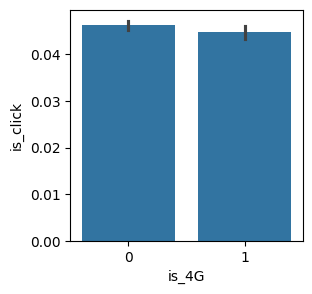

In [47]:
# Visualizing the relationship between 'is_4G' (whether the user was on a 4G network) and 'is_click' (whether the ad was clicked)
plt.figure(figsize=(3,3))
sns.barplot(master_data, x='is_4G', y='is_click')
plt.show()

#### The bar plot compares the click-through rates for users on a 4G network (is_4G = 1) versus those not on 4G (is_4G = 0). The click rates are very similar between both groups, with users on a non-4G network showing a slightly higher click-through rate.
#### This indicates that whether a user is on a 4G network or not does not have a significant impact on whether they click an ad. This feature might not add much predictive power to the model.

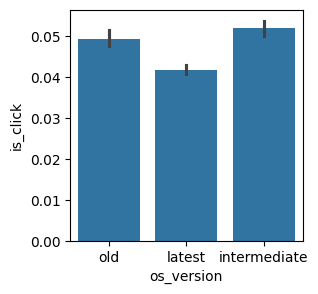

In [48]:
# Visualizing the relationship between 'os_version' (operating system version) and 'is_click'
plt.figure(figsize=(3,3))
sns.barplot(master_data, x='os_version', y='is_click')
plt.show()

#### This plot shows how the click-through rate varies across different operating system versions (old, latest, and intermediate). Users with the intermediate OS version have the highest click-through rate, followed by old OS users, while the latest OS version users have a slightly lower click rate.
#### The version of the operating system appears to influence ad-click behavior. Users with intermediate versions seem more likely to click, which could be due to device performance, compatibility, or user experience differences. This feature could be useful in the model.

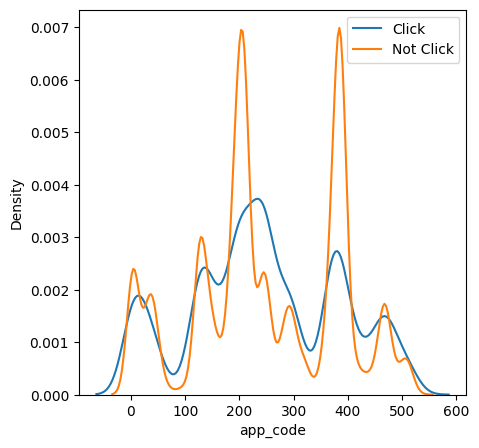

In [49]:
# KDE plot for 'app_code' (a categorical feature representing the app where the ad was displayed) grouped by whether the ad was clicked
plt.figure(figsize=(5,5))
sns.kdeplot(master_data["app_code"][master_data["is_click"] == 1])
sns.kdeplot(master_data["app_code"][master_data["is_click"] == 0])
plt.legend(['Click', 'Not Click'])
plt.show()

#### This plot compares the density of app_code (categorical feature for different apps) for clicked vs. not clicked ads. Several peaks for non-clicked ads (orange line) dominate the distribution, especially at certain app codes (e.g., around 400), indicating higher non-click activity for those apps.
#### Certain app codes clearly have higher rates of non-clicks, suggesting that app-specific behavior plays a role in whether users interact with ads. This indicates that app_code can be an important feature in predicting ad clicks.

In [50]:
# Creating new features for day of the week and hour of the day from the 'impression_time'
master_data['impression_day_of_week'] = master_data['impression_time'].dt.day_of_week
master_data['impression_hour_of_day'] = master_data['impression_time'].dt.hour


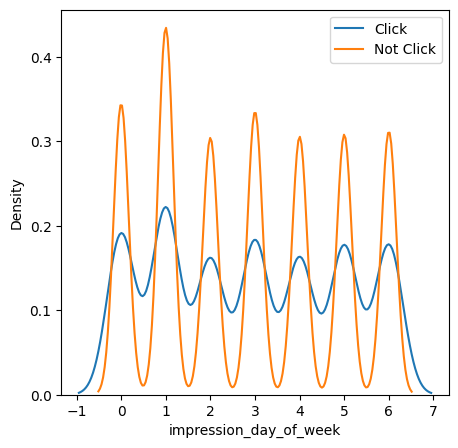

In [51]:
# KDE plot for 'impression_day_of_week' (day of the week when the ad was shown) grouped by ad clicks
plt.figure(figsize=(5,5))
sns.kdeplot(master_data["impression_day_of_week"][master_data["is_click"] == 1])
sns.kdeplot(master_data["impression_day_of_week"][master_data["is_click"] == 0])
plt.legend(['Click', 'Not Click'])
plt.show()

#### This plot shows the distribution of ad impressions across the days of the week (0 = Monday, 6 = Sunday) for both clicked and non-clicked ads. The orange line (not clicked) shows consistently higher peaks, particularly early in the week (Monday-Tuesday), whereas the blue line (clicked ads) has less variation.
#### There is a clear distinction between the days of the week when clicks are more likely. The non-clicked ads show a recurring pattern, suggesting that ad activity is high early in the week, but the likelihood of clicks is relatively lower. This feature could help capture behavioral trends tied to the day of the week in the model.

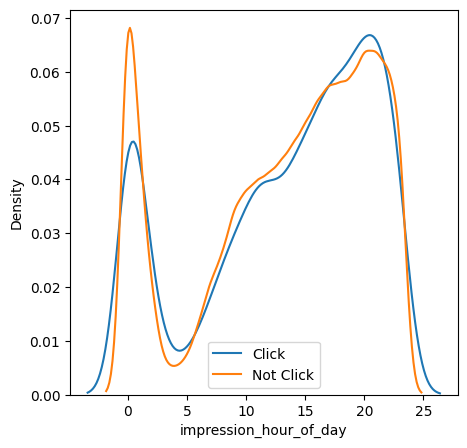

In [52]:
# KDE plot for 'impression_hour_of_day' (hour of the day when the ad was shown) grouped by ad clicks
plt.figure(figsize=(5,5))
sns.kdeplot(master_data["impression_hour_of_day"][master_data["is_click"] == 1])
sns.kdeplot(master_data["impression_hour_of_day"][master_data["is_click"] == 0])
plt.legend(['Click', 'Not Click'])
plt.show()

#### The density plot compares the hour of day when impressions were shown and whether the ads were clicked or not. Both clicked and non-clicked ads follow a similar pattern, with peaks in the early hours (around 0-1 AM) and another significant peak around 8 PM.
#### While both clicked and non-clicked impressions follow the same general pattern, there is a slightly higher density of clicks around certain hours. Late-night and evening hours seem to have higher ad activity, and this pattern could help identify times when users are more likely to engage with ads.

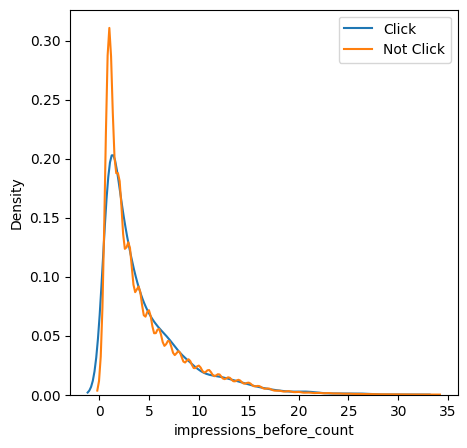

In [53]:
# KDE plot for 'impressions_before_count' (number of impressions seen by the user before the current one)
master_data1=master_data[master_data["impressions_before_count"] != 0]

plt.figure(figsize=(5,5))
sns.kdeplot(master_data1["impressions_before_count"][master_data1["is_click"] == 1])
sns.kdeplot(master_data1["impressions_before_count"][master_data1["is_click"] == 0])
plt.legend(['Click', 'Not Click'])
plt.show()

#### The first plot shows the distribution of impressions_before_count for clicked and non-clicked ads. There is a significant peak near zero impressions, particularly for non-clicked ads (orange line), indicating that users who have seen fewer impressions are more likely not to click.
#### As the number of impressions increases, both distributions (clicked and non-clicked) taper off, with very few users having seen more than 10-15 impressions. Beyond 15 impressions, both curves are nearly flat, indicating rare occurrences.
#### The peak at lower impression counts suggests that users are more likely to either click or not click after seeing only a few impressions. Users who have seen many impressions have a very low likelihood of engaging with the ad.
#### The similarity in the curves at higher values of impressions_before_count (beyond 15 impressions) suggests that there is little to no difference between users who click and those who don’t after seeing many impressions.

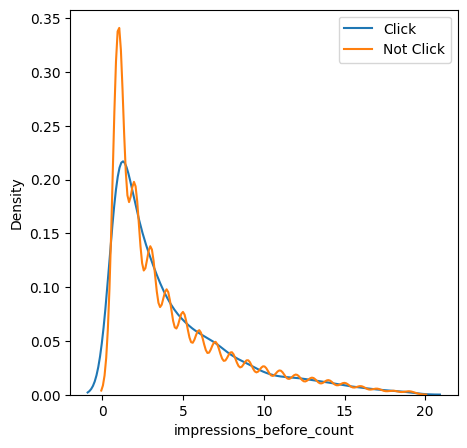

In [54]:
# KDE plot for 'impressions_before_count' with an upper limit of 20
master_data2=master_data1[master_data1["impressions_before_count"] < 20]

plt.figure(figsize=(5,5))
sns.kdeplot(master_data2["impressions_before_count"][master_data2["is_click"] == 1])
sns.kdeplot(master_data2["impressions_before_count"][master_data2["is_click"] == 0])
plt.legend(['Click', 'Not Click'])
plt.show()

#### The second plot excludes any impressions_before_count greater than 20. By capping the upper limit, we see a more focused view of the distribution, particularly in the range where most data points lie (0 to 20 impressions).
#### Similar to the first plot, non-clicked ads (orange line) dominate at very low impression counts, while clicked ads (blue line) catch up slightly as impressions increase. Both distributions show a downward trend as the number of impressions increases.
#### Limiting the impressions_before_count provides a clearer picture of user behavior at the lower end of the distribution, where most users are clustered. The distribution shows that users who have seen fewer impressions are less likely to click on ads.
#### This refined view indicates that the higher end of the impression count (above 10) is less informative, as the difference between clicks and non-clicks diminishes significantly.

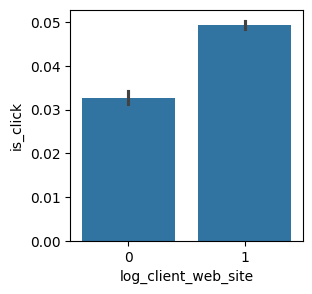

In [55]:
# Creating a binary feature 'log_client_web_site' to identify if the user visited the website based on 'log_client_web_site_count'
master_data['log_client_web_site'] = np.where(master_data['log_client_web_site_count']!=0, 1, 0)

# Bar plot for 'log_client_web_site' (whether the user visited the client website) vs 'is_click'
plt.figure(figsize=(3,3))
sns.barplot(master_data, x='log_client_web_site', y='is_click')
plt.show()

#### The bar plot shows the relationship between the binary variable log_client_web_site (indicating whether the user visited the client website or not) and the probability of clicking on an ad (is_click).
#### Users who have visited the client website (log_client_web_site = 1) are more likely to click on the ad, with a click rate close to 5%. In contrast, users who haven't visited the website have a lower click rate of around 3%.
#### This suggests a clear correlation between a user's past behavior (website visits) and their likelihood of interacting with future ads. Users who visit the website are significantly more engaged and thus more likely to click on related ads.
#### log_client_web_site is a strong feature for predicting ad clicks and should be retained in the model.

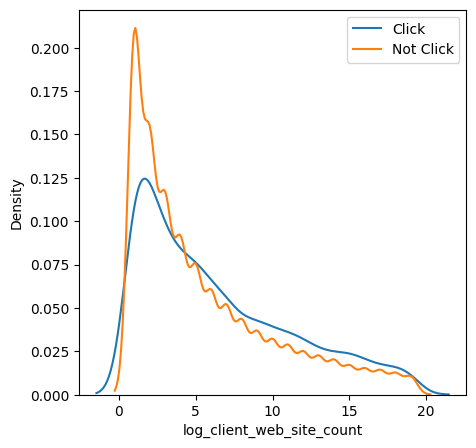

In [56]:
# KDE plot for 'log_client_web_site_count' (number of website visits before the current ad impression)
master_data1=master_data[master_data["log_client_web_site_count"] != 0]
master_data2=master_data1[master_data1["log_client_web_site_count"] < 20]

plt.figure(figsize=(5,5))
sns.kdeplot(master_data2["log_client_web_site_count"][master_data2["is_click"] == 1])
sns.kdeplot(master_data2["log_client_web_site_count"][master_data2["is_click"] == 0])
plt.legend(['Click', 'Not Click'])
plt.show()

#### This plot shows the density of log_client_web_site_count (number of website visits before the current ad impression) for clicked and non-clicked ads. The orange line (not clicked) has a steep peak near zero visits, indicating that most users who didn't click on the ad had very few or no previous visits to the website. The blue line (clicked ads) shows a slightly more spread-out distribution. While many users who clicked also had few website visits, there is a longer tail for clicked ads, meaning users with more website visits are more likely to click.
####  Users who have visited the client website multiple times are more likely to click on ads. However, most non-clicked users have very few or zero website visits.
#### This trend suggests that log_client_web_site_count can help predict the likelihood of an ad click, as users with more website visits demonstrate higher engagement levels. Limiting the count to under 20, as done in the plot, helps focus on the most relevant portion of the data, where user behavior differs the most.

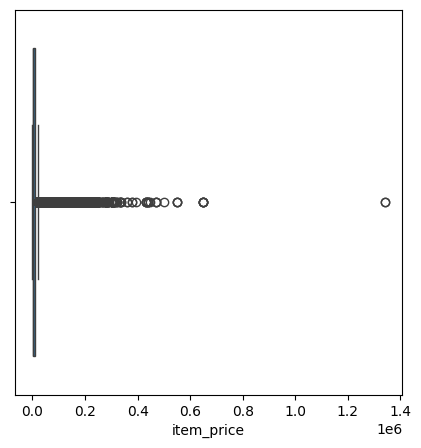

In [57]:
# Box plot for 'item_price' (the price of the product shown in the ad)
plt.figure(figsize=(5,5))
sns.boxplot(master_data1, x='item_price')
plt.show()

#### In this plot, the distribution of item_price shows a large number of outliers on the higher end, with values extending far beyond the whiskers (as high as 1.4 million). The vast majority of the data is concentrated at the lower end, indicating that most items are priced relatively low.
#### The presence of extreme outliers suggests that there are a few items with significantly higher prices, which could disproportionately affect any statistical analysis or machine learning model.
#### Without handling the outliers, the item_price feature is highly skewed, which could lead to poor model performance, especially for models sensitive to feature scaling or distribution (e.g., linear regression, KNN).
#### The extreme range of values makes it important to apply some form of outlier handling to reduce their impact.

In [58]:
# Find the outliers for 'item_price' based on a 3 standard deviation rule

Upper_boundary = master_data1.item_price.mean() + 3* master_data1.item_price.std()
Lower_boundary = master_data1.item_price.mean() - 3* master_data1.item_price.std()
print('item_price outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_boundary, upperboundary=Upper_boundary))


item_price outliers are values < -70829.62445846855 or > 94443.24142560389


In [59]:
# Describe the item_price distribution
master_data1.item_price.describe()

count    1.854880e+05
mean     1.180681e+04
std      2.754548e+04
min      0.000000e+00
25%      1.459000e+03
50%      2.822000e+03
75%      8.960000e+03
max      1.340800e+06
Name: item_price, dtype: float64

In [60]:
# Top-coding the 'item_price' variable to remove outliers (values above a threshold are capped)
master_data1.loc[master_data1.item_price>94443, 'item_price'] = 94443
master_data1.item_price.max()

94443.0

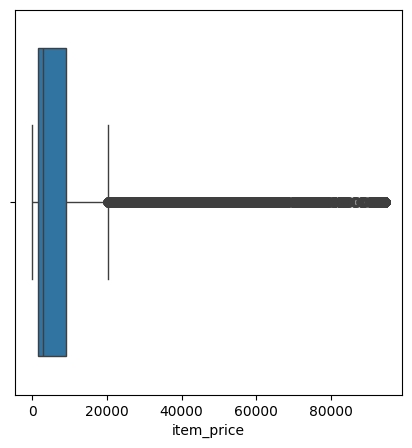

In [61]:
# Box plot for 'item_price' to visualize the distribution and detect outliers
plt.figure(figsize=(5,5))
sns.boxplot(master_data1, x='item_price')
plt.show()

#### After handling outliers (likely by capping or clipping the maximum price), the boxplot shows a much more concentrated and compressed range. Most of the data now lies within a more reasonable range, with the maximum price significantly reduced compared to the first plot.
#### The majority of data points are now within a narrow range, with fewer extreme values, which has compressed the upper whisker.
#### The outlier handling (e.g., capping the price at a reasonable threshold like the 95th percentile) has successfully reduced the impact of extreme prices. This should result in a more robust and stable model, as the outliers no longer dominate the distribution.
#### By capping extreme values, the feature distribution becomes more normal and likely easier to model. Additionally, this reduces the likelihood of models overfitting to the outliers.


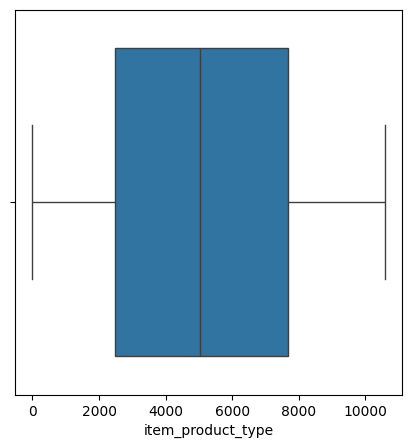

In [62]:
# Exploration of 'item_product_type' feature
plt.figure(figsize=(5,5))
sns.boxplot(master_data1, x='item_product_type')
plt.show()

#### The boxplot for item_product_type shows a fairly even spread across the range, with no major outliers. The distribution is relatively uniform, indicating a broad variety of product types.
#### The diversity in product types suggests that different product categories may have different ad click-through rates. It would be useful to investigate whether certain product types are more likely to result in clicks.

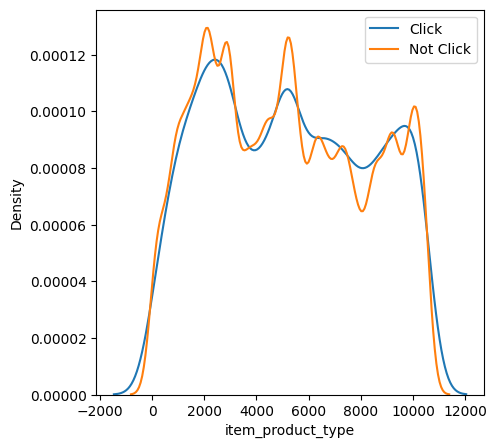

In [63]:
# KDE plot for 'item_product_type' to compare ad clicks vs non-clicks
plt.figure(figsize=(5,5))
sns.kdeplot(master_data1["item_product_type"][master_data1["is_click"] == 1])
sns.kdeplot(master_data1["item_product_type"][master_data1["is_click"] == 0])
plt.legend(['Click', 'Not Click'])
plt.show()

#### The KDE plot shows overlapping distributions for both clicked and not-clicked ads. There are some peaks where the distribution for clicked ads exceeds that of non-clicked ads, indicating that some product types are more likely to generate clicks.
#### The relatively small distinction between the two curves suggests that item_product_type may not be a strong distinguishing feature on its own. However, combining it with other features could reveal more significant patterns.


<Axes: xlabel='item_category_3'>

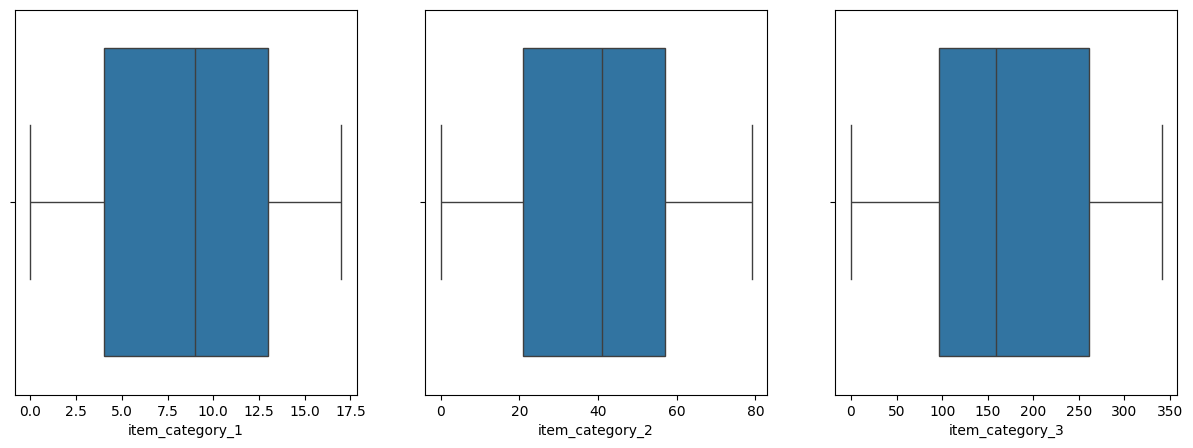

In [64]:
# Box plots for 'item_category_1', 'item_category_2', and 'item_category_3' to check for distribution and potential outliers
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
# item_category_1
sns.boxplot(ax=axes[0], x=master_data1["item_category_1"])
# item_category_2
sns.boxplot(ax=axes[1], x=master_data1["item_category_2"])
# item_category_3
sns.boxplot(ax=axes[2], x=master_data1["item_category_3"])

#### item_category_1 and item_category_2 have a fairly uniform distribution with a range of values, while item_category_3 spans a larger range.
#### The lack of extreme outliers suggests these categories are relatively clean, though they still show a wide range of values.
#### Since these categories are numerical, they could still provide useful information for classification. The broad range in these categories suggests that some categories might influence user behavior more than others.

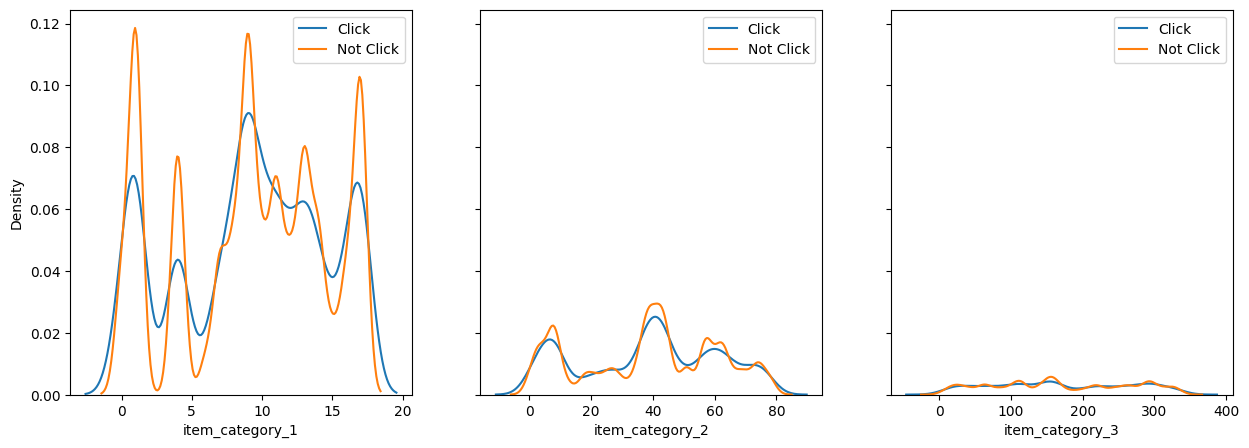

In [65]:
# KDE plots for 'item_category_1', 'item_category_2', and 'item_category_3' to explore the relationship with ad clicks
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True);

# item_category_1
sns.kdeplot(ax=axes[0], x=master_data1["item_category_1"][master_data1["is_click"] == 1]);
sns.kdeplot(ax=axes[0], x=master_data1["item_category_1"][master_data1["is_click"] == 0]);
axes[0].legend(['Click', 'Not Click']);

# item_category_2
sns.kdeplot(ax=axes[1], x=master_data1["item_category_2"][master_data1["is_click"] == 1]);
sns.kdeplot(ax=axes[1], x=master_data1["item_category_2"][master_data1["is_click"] == 0]);
axes[1].legend(['Click', 'Not Click']);

# item_category_2
sns.kdeplot(ax=axes[2], x=master_data1["item_category_3"][master_data1["is_click"] == 1]);
sns.kdeplot(ax=axes[2], x=master_data1["item_category_3"][master_data1["is_click"] == 0]);
axes[2].legend(['Click', 'Not Click']);


#### item_category_1: This plot shows distinct peaks for clicked and non-clicked ads, with several regions where one group dominates over the other. This suggests that item_category_1 could be an important predictor of clicks.
#### item_category_2 and item_category_3: These categories show less variation between clicked and non-clicked ads, suggesting that they may not be as useful for predicting ad clicks on their own.
#### While item_category_1 shows promise as a distinguishing feature, item_category_2 and item_category_3 may need to be combined with other features to improve their predictive power.

In [66]:
# Selecting relevant columns for further analysis and model building
columns = ['impression_day_of_week','impression_hour_of_day','app_code', 'os_version', 'is_4G','impressions_before_count','log_client_web_site_count','log_client_web_site_device_type','item_price','item_product_type','item_category_1','item_category_2','item_category_3','is_click']
# Creating a new dataframe with selected columns
master_data_result= master_data[columns].copy()

In [67]:
# Encoding categorical columns for model readiness
categorical_columns = ['os_version','log_client_web_site_device_type']
# Initialize the ordinal encoder
encoder = OrdinalEncoder()
# Encode the categorical columns
master_data_result[categorical_columns]=encoder.fit_transform(master_data_result[categorical_columns])


In [68]:
# Convert encoded columns to integer type for easier analysis
master_data_result['os_version'] = master_data_result['os_version'].astype('int')
master_data_result['log_client_web_site_device_type'] = master_data_result['log_client_web_site_device_type'].astype('int')

In [69]:
# Feature scaling to normalize numerical data
columns_for_scaling = ['app_code','log_client_web_site_count','item_price','item_product_type','item_category_3']
# Initialize the scaler
scaler = StandardScaler()
# Apply scaling to the selected columns
master_data_result[columns_for_scaling] = scaler.fit_transform(master_data_result[columns_for_scaling])


In [70]:
master_data_result.head()

,impression_day_of_week,impression_hour_of_day,app_code,os_version,is_4G,impressions_before_count,log_client_web_site_count,log_client_web_site_device_type,item_price,item_product_type,item_category_1,item_category_2,item_category_3,is_click
0,3,0,1.278720,2,0,0,-0.603599,2,-0.371305,-1.178765,0,0,-1.210864,0
1,3,0,1.611528,1,1,0,-0.603599,2,-0.371305,-1.178765,0,0,-1.210864,1
2,3,0,0.073218,0,1,0,-0.603599,2,-0.371305,-1.178765,0,0,-1.210864,0
3,3,0,-0.037718,1,1,0,0.176800,0,-0.306808,0.896750,14,61,0.237936,0
4,3,0,1.655902,1,0,0,0.003378,0,-0.187765,1.517678,7,24,-0.299669,0


In [71]:
# Correlation analysis between selected numerical columns
columns = ['impressions_before_count','log_client_web_site_count','item_price']
# Calculate the correlation matrix
corr = master_data_result[columns].corr()
corr

,impressions_before_count,log_client_web_site_count,item_price
impressions_before_count,1.000000,0.124660,0.025937
log_client_web_site_count,0.124660,1.000000,0.049325
item_price,0.025937,0.049325,1.000000


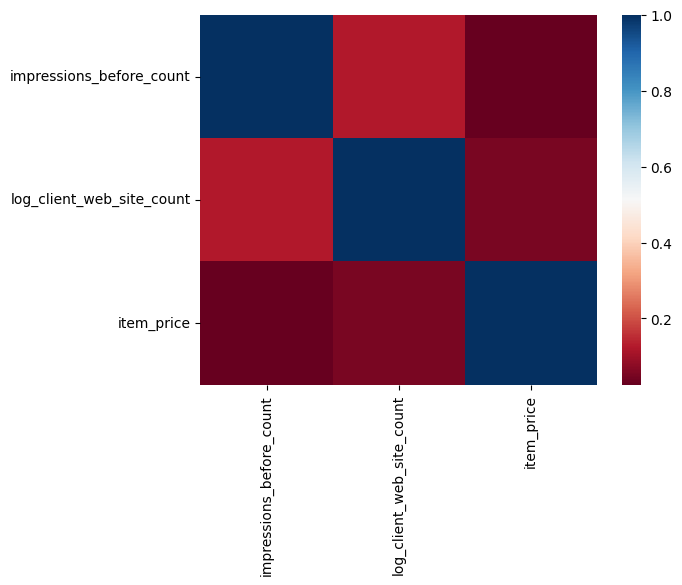

In [72]:
# Create a heatmap with a red-blue color scale to visualize the correlations
sns.heatmap(corr, cmap="RdBu")
plt.show()

#### The heatmap reveals very weak correlations between the selected features: impressions_before_count and log_client_web_site_count have a slight positive correlation (~0.12).
#### item_price has almost no correlation with the other two features, indicating that price is independent of the number of impressions or website interactions.
#### The low correlations suggest that these features are not collinear and should be included in the model. Their independence may contribute to capturing different aspects of user behavior. However, since no strong correlations exist, each feature’s individual predictive power needs to be evaluated.

## Machine Learning

In [73]:
# Specify Prediction Target and data for ML
y = master_data_result.is_click
X = master_data_result.drop('is_click', axis=1)

## Logistic Regression

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

Train/Test split results:
Accuracy is 0.956
Logarithmic loss is 0.180
The Area Under the ROC (AUC) curve is 0.568


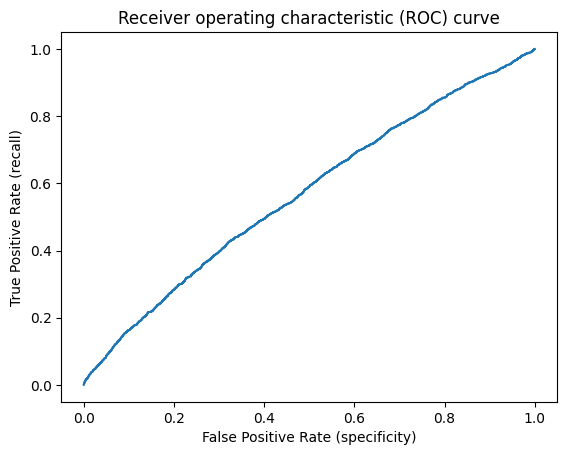

In [75]:
# Model evaluation based on simple train/test split using train_test_split() function

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)

print('Train/Test split results:')
print("Accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print("Logarithmic loss is %2.3f" % log_loss(y_test, y_pred_proba))
print("The Area Under the ROC (AUC) curve is %2.3f" % auc(fpr, tpr))

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate (specificity)')
plt.ylabel('True Positive Rate (recall)')
plt.title('Receiver operating characteristic (ROC) curve')
plt.show()

#### The ROC curve is almost a diagonal line, suggesting that the model is not performing much better than random guessing.

In [76]:
# Model evaluation based on K-fold cross-validation using cross_val_score() function

logreg = LogisticRegression()
scores_accuracy = cross_val_score(logreg, X_train, y_train, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(logreg, X_train, y_train, cv=10, scoring='neg_log_loss')
scores_auc = cross_val_score(logreg, X_train, y_train, cv=10, scoring='roc_auc')

print('K-fold cross-validation results:')
print("Average Accuracy is %2.3f" % scores_accuracy.mean())
print("Average Logarithmic Loss is %2.3f" % -scores_log_loss.mean())
print("The Average Area Under the ROC (AUC) Curve is %2.3f" % scores_auc.mean())

K-fold cross-validation results:
Average Accuracy is 0.954
Average Logarithmic Loss is 0.185
The Average Area Under the ROC (AUC) Curve is 0.572


#### The performance of Logistic Regression is consistent across both train/test split and cross-validation, but the AUC score is quite low (around 0.57), indicating that the model struggles to differentiate between classes. The model's accuracy is high due to the imbalanced nature of the dataset (many non-clicks), but the AUC shows it is not a strong model for predicting clicks.

In [77]:
# Model hyperparameter tuning with GridSearchCV

parameters = {"C": [0.001, 0.01, 0.1, 1.], "penalty": ["l1", "l2"]}
logreg = LogisticRegression()

model_logreg = GridSearchCV(logreg, parameters, cv=10, scoring='roc_auc')
model_logreg.fit(X_train, y_train)

print('Hyperparameter tuning with GridSearchCV')
print(f'Best parameters {model_logreg.best_params_}')

print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + 
    f'{model_logreg.best_score_:.3f}'
)

Hyperparameter tuning with GridSearchCV
Best parameters {'C': 0.001, 'penalty': 'l2'}
Mean cross-validated accuracy score of the best_estimator: 0.573


#### Even after hyperparameter tuning, Logistic Regression does not significantly improve its AUC. This suggests that the linear nature of Logistic Regression may not be well-suited for this problem.

## Decision Trees

In [78]:
# Split Data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1)

In [79]:

# Specify the model. 
# For model reproducibility, set a numeric value for random_state when specifying the model
model_tree = DecisionTreeClassifier(random_state=1)

# Fit the model with the training data.
model_tree.fit(train_X, train_y)

DecisionTreeClassifier(random_state=1)

Train/Test split results:
Accuracy is 0.912
Logarithmic loss is 3.177
The Area Under the ROC (AUC) curve is 0.522


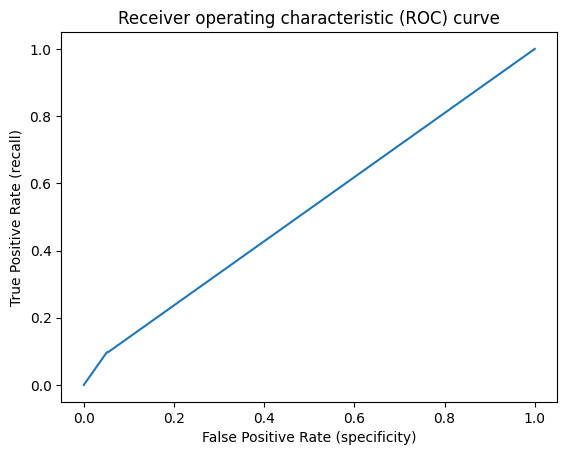

In [80]:
# Make Predictions with Validation data
# Predict with all validation observations
y_pred = model_tree.predict(val_X)
y_pred_proba = model_tree.predict_proba(val_X)[:, 1]
[fpr, tpr, thr] = roc_curve(val_y, y_pred_proba)

print('Train/Test split results:')
print("Accuracy is %2.3f" % accuracy_score(val_y, y_pred))
print("Logarithmic loss is %2.3f" % log_loss(val_y, y_pred_proba))
print("The Area Under the ROC (AUC) curve is %2.3f" % auc(fpr, tpr))

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate (specificity)')
plt.ylabel('True Positive Rate (recall)')
plt.title('Receiver operating characteristic (ROC) curve')
plt.show()

#### The ROC curve is closer to the diagonal line, indicating poor performance in terms of distinguishing between clicks and non-clicks.

In [81]:
def get_auc(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes, random_state=1)
    model.fit(train_X, train_y)
    y_pred = model.predict(val_X)
    y_pred_proba = model.predict_proba(val_X)[:, 1]
    [fpr, tpr, thr] = roc_curve(val_y, y_pred_proba)
    return(auc(fpr, tpr))

In [82]:
# Compare Different Tree Sizes
candidate_max_leaf_nodes = [5, 25, 50, 100, 250, 500]
# Write loop to find the ideal tree size from candidate_max_leaf_nodes
for max_leaf_nodes in candidate_max_leaf_nodes:
    my_auc = get_auc(max_leaf_nodes, train_X, val_X, train_y, val_y)
    print("Max leaf nodes: %d  \t\t The Area Under the ROC (AUC) curve is %2.3f" %(max_leaf_nodes, my_auc))

Max leaf nodes: 5  		 The Area Under the ROC (AUC) curve is 0.615
Max leaf nodes: 25  		 The Area Under the ROC (AUC) curve is 0.685
Max leaf nodes: 50  		 The Area Under the ROC (AUC) curve is 0.690
Max leaf nodes: 100  		 The Area Under the ROC (AUC) curve is 0.688
Max leaf nodes: 250  		 The Area Under the ROC (AUC) curve is 0.688
Max leaf nodes: 500  		 The Area Under the ROC (AUC) curve is 0.678


#### Best AUC: 0.690 with 50 leaf nodes
#### Decision trees provide some flexibility in capturing non-linear relationships. The AUC improves as you increase the complexity of the tree, peaking around 50 leaf nodes. However, the model is still underperforming, with a relatively low AUC compared to other models. The high logarithmic loss indicates that the predicted probabilities are not well-calibrated.

## Random Forest

In [83]:
# Define the model. Set random_state to 1
rf_model = RandomForestClassifier(random_state=1)

# fit your model
rf_model.fit(train_X, train_y)

RandomForestClassifier(random_state=1)

Train/Test split results:
Accuracy is 0.951
Logarithmic loss is 0.317
The Area Under the ROC (AUC) curve is 0.652


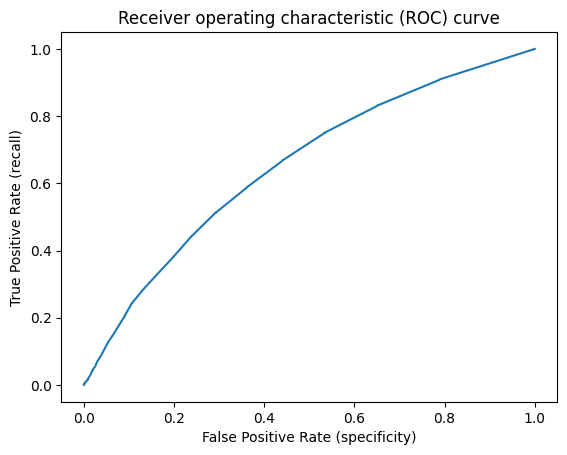

In [84]:
# Make Predictions with Validation data
# Predict with all validation observations
y_pred = rf_model.predict(val_X)
y_pred_proba = rf_model.predict_proba(val_X)[:, 1]
[fpr, tpr, thr] = roc_curve(val_y, y_pred_proba)

print('Train/Test split results:')
print("Accuracy is %2.3f" % accuracy_score(val_y, y_pred))
print("Logarithmic loss is %2.3f" % log_loss(val_y, y_pred_proba))
print("The Area Under the ROC (AUC) curve is %2.3f" % auc(fpr, tpr))

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate (specificity)')
plt.ylabel('True Positive Rate (recall)')
plt.title('Receiver operating characteristic (ROC) curve')
plt.show()

#### The curve is noticeably better than Logistic Regression and Decision Trees, with a larger area under the curve.

#### Random Forest outperforms Logistic Regression and Decision Trees, with a higher AUC (0.652). This suggests that the ensemble method (Random Forest) is better at capturing more complex patterns in the data, which may be missed by simpler models. However, the logarithmic loss is still relatively high, indicating room for improvement in probability calibration.

## XGBoost

In [85]:

# Define the model
model_XGB = XGBClassifier(random_state=0)

# Fit the model
model_XGB.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

Accuracy is 0.955
Logarithmic loss is 0.155
The Area Under the ROC (AUC) curve is 0.809


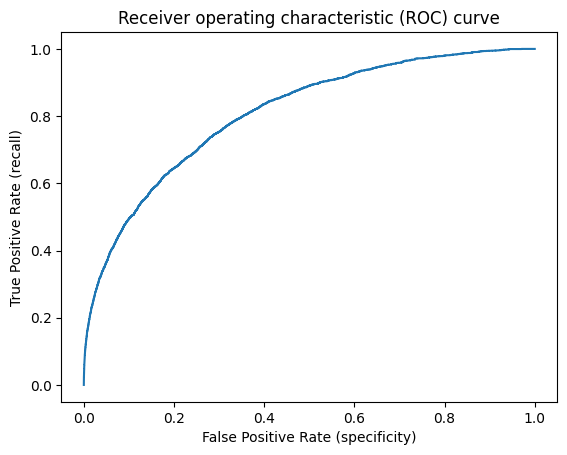

In [86]:
# Make Predictions with Validation data
# Predict with all validation observations
y_pred = model_XGB.predict(val_X)
y_pred_proba = model_XGB.predict_proba(val_X)[:, 1]
[fpr, tpr, thr] = roc_curve(val_y, y_pred_proba)

print("Accuracy is %2.3f" % accuracy_score(val_y, y_pred))
print("Logarithmic loss is %2.3f" % log_loss(val_y, y_pred_proba))
print("The Area Under the ROC (AUC) curve is %2.3f" % auc(fpr, tpr))

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate (specificity)')
plt.ylabel('True Positive Rate (recall)')
plt.title('Receiver operating characteristic (ROC) curve')
plt.show()

#### The ROC curve is the best among all models, with a large area under the curve, indicating strong performance.
####  XGBoost outperforms all other models, with a much higher AUC (0.809) and lower logarithmic loss (0.155). This suggests that XGBoost is better at learning from the data and making more accurate predictions. It captures both the patterns in the data and handles the imbalance in the target class (click vs. no click) more effectively. The ROC curve shows that the model has a much better trade-off between true positive rate and false positive rate.